# Ensemble Classifiers
## Hyperparameter tuning with grid search and cross-validation

<img src="../images/ensemble.png" width="600">



The goal of **ensemble methods** is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator.
<br>
<br>
Two families of ensemble methods are usually distinguished:
* In averaging methods, the driving principle is to build several estimators independently and then to average their predictions. On average, the combined estimator is usually better than any of the single base estimator because its variance is reduced.
    * **Examples: Bagging methods, Forests of randomized trees, ...**
* By contrast, in boosting methods, base estimators are built sequentially and one tries to reduce the bias of the combined estimator. The motivation is to combine several weak models to produce a powerful ensemble.
    * **Examples: AdaBoost, Gradient Tree Boosting, ...**

## Import Python Libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload

## Import Utility Classes

In [2]:
%autoreload 2
import sys
sys.path.append('..')

from utils.data_loader import DataLoader
from utils.term_counter_helper import TermFrequency, TfIdf
from utils.data_frame_helper import DataFrameHelper
from utils.model_evaluation_helper import ModelEvaluationHelper
from utils.classifier_helper import Classifier

## Load Data

In [3]:
loader = DataLoader()
content = loader.load_data("../Data/trainingdata.txt")

Number of Sentences:  5485



In [4]:
label_names = np.array(["A", "B", "C", "D", "E", "F", "G", "H"])
df = loader.get_data_frame(content, label_names)
df_helper = DataFrameHelper(df, label_names)

## Input Dataset in DataFrame Format

In [5]:
df_helper.df.head()

,Labels,Text
0,A,champion products ch approves stock split cham...
1,B,computer terminal systems cpml completes sale ...
2,A,cobanco inc cbco year net shr cts vs dlrs net ...
3,A,am international inc am nd qtr jan oper shr lo...
4,A,brown forman inc bfd th qtr net shr one dlr vs...


## TF-IDF Featurization

In [6]:
min_df = 2

tfidf = TfIdf(
    label_names,
    norm='l2',
    smooth_idf = True,
    sublinear_tf = False,
    lowercase=True,
    preprocessor=None,
    tokenizer=None,
    stop_words='english',
    ngram_range=(1, 1),
    analyzer='word',
    max_df=0.8, # 0.5, 0.75, 1.0
    min_df = min_df,
    max_features=None,
    vocabulary=None)



tfidf.vectorize_corpus(df_helper.raw_text)
tfidf.vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=None, min_df=2,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

## Split Dataset into Trainset and Testset

In [7]:
tfidf_model_evaluation = ModelEvaluationHelper(
    tfidf.X, df_helper.y, test_size=0.3, random_state=3, label_names = df_helper.label_names)

## Random Forest
In **random forests**, each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set. In addition, when splitting a node during the construction of the tree, the split that is chosen is no longer the best split among all features. Instead, the split that is picked is the best split among a random subset of the features. As a result of this randomness, the bias of the forest usually slightly increases (with respect to the bias of a single non-random tree) but, due to averaging, its variance also decreases, usually more than compensating for the increase in bias, hence yielding an overall better model.
<br>
<br>
This particular implementation combines classifiers by averaging their probabilistic prediction, instead of letting each classifier vote for a single class.

<img src="../images/RF.png" width="600">


## Hyperparameter Search Space

In [8]:
hyperparameters = {
    'n_estimators': (30, 50, 100),
    'max_features': ("sqrt","log2")
}

## Random Forest Classifier

In [9]:
clf = Classifier()
randomForest = clf.multinomial_Ensemble_clf("randomForest", class_weight="balanced")

## Run Grid Search with Cross Validation

In [10]:
tfidf_model_evaluation.set_hyperparam_grid(hyperparameters)
tfidf_model_evaluation.cross_val_grid_search(randomForest, "f1_weighted", cv = 5)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/marvin/anaconda2/envs/Notebook-env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/marvin/anaconda2/envs/Notebook-env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/marvin/anaconda2/envs/Notebook-env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/marvin/anaconda2/envs/Notebook-env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.

Best score: 0.934
Best parameters set:
	max_features: 'sqrt'
	n_estimators: 50

Grid scores on training set:

0.925 (+/-0.018) for {'n_estimators': 30, 'max_features': 'sqrt'}
0.934 (+/-0.026) for {'n_estimators': 50, 'max_features': 'sqrt'}
0.932 (+/-0.012) for {'n_estimators': 100, 'max_features': 'sqrt'}
0.891 (+/-0.009) for {'n_estimators': 30, 'max_features': 'log2'}
0.892 (+/-0.026) for {'n_estimators': 50, 'max_features': 'log2'}
0.901 (+/-0.021) for {'n_estimators': 100, 'max_features': 'log2'}

Detailed classification report:

The model is trained on the full train set with cross-validation.
The scores are computed on the full test set.

             precision    recall  f1-score   support

          A       0.99      0.96      0.97       826
          B       0.90      0.98      0.94       511
          C       0.87      0.92      0.89        63
          D       1.00      0.69      0.82        42
          E       0.83      0.50      0.62        10
          F       0.95    

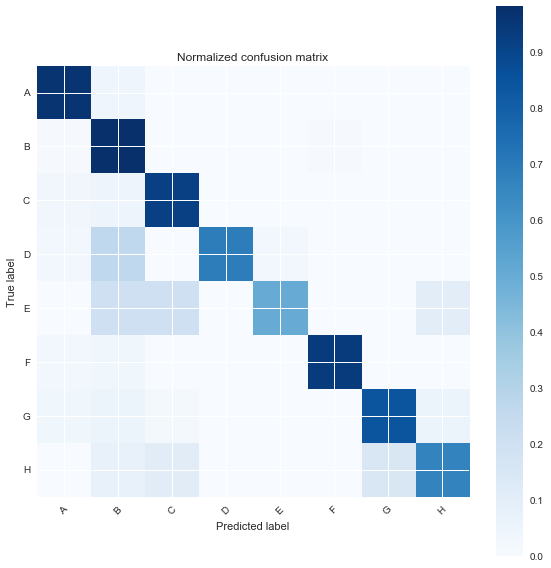

In [11]:
tfidf_model_evaluation.confusion_matrix()

##  Extremely Randomized Trees

In **extremely randomized trees**, randomness goes one step further in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias.

## Extremely Randomized Trees Classifier

In [12]:
extraTrees = clf.multinomial_Ensemble_clf("extraTrees", class_weight="balanced")

## Run Grid Search with Cross Validation

In [13]:
tfidf_model_evaluation.set_hyperparam_grid(hyperparameters)
tfidf_model_evaluation.cross_val_grid_search(extraTrees, "f1_weighted", cv = 5)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/marvin/anaconda2/envs/Notebook-env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   34.0s finished


Best score: 0.943
Best parameters set:
	max_features: 'sqrt'
	n_estimators: 100

Grid scores on training set:

0.938 (+/-0.018) for {'n_estimators': 30, 'max_features': 'sqrt'}
0.940 (+/-0.017) for {'n_estimators': 50, 'max_features': 'sqrt'}
0.943 (+/-0.024) for {'n_estimators': 100, 'max_features': 'sqrt'}
0.895 (+/-0.022) for {'n_estimators': 30, 'max_features': 'log2'}
0.908 (+/-0.016) for {'n_estimators': 50, 'max_features': 'log2'}
0.908 (+/-0.024) for {'n_estimators': 100, 'max_features': 'log2'}

Detailed classification report:

The model is trained on the full train set with cross-validation.
The scores are computed on the full test set.

             precision    recall  f1-score   support

          A       0.99      0.97      0.98       826
          B       0.92      0.99      0.95       511
          C       0.89      0.94      0.91        63
          D       1.00      0.81      0.89        42
          E       1.00      0.40      0.57        10
          F       1.00   

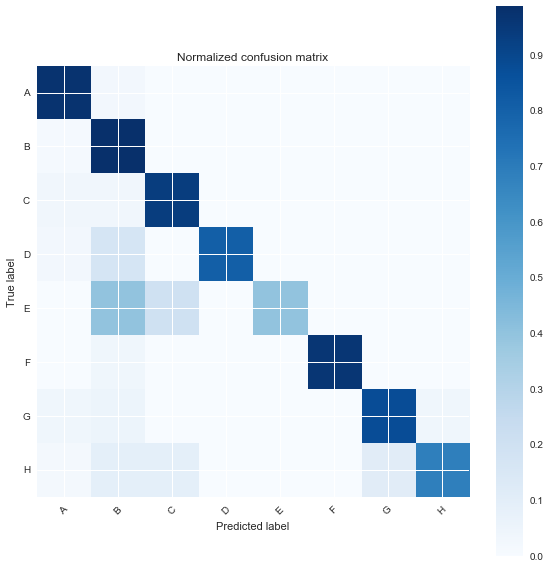

In [14]:
tfidf_model_evaluation.confusion_matrix()

## AdaBoost

The core principle of **AdaBoost** is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data. The predictions from all of them are then combined through a weighted majority vote (or sum) to produce the final prediction. 
<br>
<br>
The data modifications at each so-called boosting iteration consist of applying weights $w_1, w_2, ..., w_N$ to each of the training samples. Initially, those weights are all set to $w_i = 1/N$, so that the first step simply trains a weak learner on the original data. For each successive iteration, the sample weights are individually modified and the learning algorithm is reapplied to the reweighted data.
<br>
<br>
At a given step, those training examples that were incorrectly predicted by the boosted model induced at the previous step have their weights increased, whereas the weights are decreased for those that were predicted correctly. As iterations proceed, examples that are difficult to predict receive ever-increasing influence. Each subsequent weak learner is thereby forced to concentrate on the examples that are missed by the previous ones in the sequence.

<img src="../images/AB.png" width="400">

## AdaBoost Classifier

In [15]:
adaBoost = clf.multinomial_Ensemble_clf("adaBoost")

## Hyperparameter Search Space

In [16]:
hyperparameters = {
    'n_estimators': (30, 50, 100),
    'learning_rate': (0.1,1.0,5.0)
}

## Run Grid Search with Cross Validation

In [17]:
tfidf_model_evaluation.set_hyperparam_grid(hyperparameters)
tfidf_model_evaluation.cross_val_grid_search(adaBoost, "accuracy", cv = 5)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  1.6min finished


Best score: 0.710
Best parameters set:
	learning_rate: 1.0
	n_estimators: 50

Grid scores on training set:

0.667 (+/-0.023) for {'learning_rate': 0.1, 'n_estimators': 30}
0.672 (+/-0.021) for {'learning_rate': 0.1, 'n_estimators': 50}
0.685 (+/-0.029) for {'learning_rate': 0.1, 'n_estimators': 100}
0.709 (+/-0.077) for {'learning_rate': 1.0, 'n_estimators': 30}
0.710 (+/-0.077) for {'learning_rate': 1.0, 'n_estimators': 50}
0.710 (+/-0.076) for {'learning_rate': 1.0, 'n_estimators': 100}
0.326 (+/-0.234) for {'learning_rate': 5.0, 'n_estimators': 30}
0.449 (+/-0.282) for {'learning_rate': 5.0, 'n_estimators': 50}
0.571 (+/-0.215) for {'learning_rate': 5.0, 'n_estimators': 100}

Detailed classification report:

The model is trained on the full train set with cross-validation.
The scores are computed on the full test set.

             precision    recall  f1-score   support

          A       1.00      0.73      0.84       826
          B       0.57      0.95      0.71       511
      

/Users/marvin/anaconda2/envs/Notebook-env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


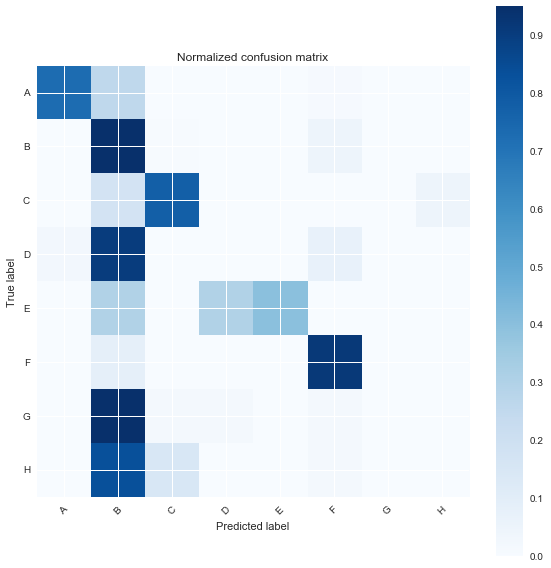

In [18]:
tfidf_model_evaluation.confusion_matrix()